In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from scipy.interpolate import interp1d

In [72]:
# Size scaling, figsize is given in inches so we need to scale it to the width we require for our paper
# An A4 papers dimensions are 21cm x 29.7cm so:
cm =  1/2.54 
margin = 2.5*cm
pt_inch = 1/72.27
column_sep = 20*pt_inch
twocolumn_width = (21*cm - 2*margin)*3
column_width = (21*cm - 2*margin - column_sep)


# Turns out scaling doesnt work the way I hoped it woudl so we will jsut use double values as scaling is required anyway
# So using the numbers above while trying to get the resulting text to be 10pt is not possible, could make the graphs bigger but this way text is approx 8-9 pt so good enough


# For two column plots then we use twocolumn_width and for one column use column_width

# Set default plt params
plt.rc('font', size=10)
plt.rc('font', family='serif')
plt.rc('font', serif="Times New Roman")
plt.rc('figure', titlesize=14) # TODO: Change axis label size to something larger then decrease tick size and see if it fits that way


In [73]:
# Set model dir:

model_dir = '/home/felix/USINE/SLIM_out'
data_dir = '/home/felix/USINE/data/USINE_FILES'


latex_format = {'Va':'V_{a}', 'Vc':'V_c', 'K0':'K_0', 'delta':'\delta', 'eta_t':'\eta_t', 'Rbreak':'R_{break}','Deltabreak':'\delta_{break}','sbreak':'s_{break}','Rlow':'R_{low}', 'deltalow':'\delta_{low}', 'slow':'s_{low}'}

# Read out file
transport_params = {}
with open(model_dir+'/model_vals_pars.out', 'r') as f:
    lines = f.readlines()
    cond = False
for line in lines:
    if '# Source' in line:
        cond = False
        break 
    if cond and line!='\n':
        key, value = line.split('=')
        # Latex format key
        key = latex_format[key.strip(' ')]
        # Add units
        key = key + ' (' + value.split('[')[1].split(']')[0] + ')'
        if key.strip(' ') not in transport_params.keys():   
            transport_params[key.strip(' ')] = float(value.split('[')[0].strip(' '))
    if '# Transport' in line:
        cond = True
# Read .C files for Double ts to retrieve data for isotopes etc. 
C_dat = {}
for i in os.listdir(model_dir):
    if i.endswith('.C'):
        with open(os.path.join(model_dir, i), 'r') as f:
            lines = f.readlines()
        cond = False
        for line in lines:
            # If stop not found
            if cond:
                if '}' not in line:
                    content.append(float(line.strip('\n').strip(',').strip(';').strip('')))
                else:
                    content.append(float(line.strip('\n').strip(',').strip(';').strip('')[:-1:]))
            # Recognize start
            if 'Double_t' in line:
                name = line[12::].split('[')[0] # Gives data descriptor
                content = []
                cond = True
            # Find stop
            if "}" in line and cond:
                cond = False
                C_dat[name] = content


AMS_data = {} # TODO: Load and format ams data for plotting

for i in os.listdir(data_dir):
    if 'orig' not in i and 'cov' not in i and 'prelim' not in i and "DAMPE" not in i and 'CALET' not in i and 'BC_AMS02.USINE' not in i:
        with open(os.path.join(data_dir, i), 'r') as f:
            try:
                lines = f.readlines()
            except:
                print(os.path.join(data_dir, i))
                pass
        commented_lines = len([i for i in lines if '#' in i])
        lines = [i for i in lines if '#   Col.' in i]
        headers = [i.split('-')[1].strip('\n').strip(' ') for i in lines]
        try:
            AMS_data[i.split('_')[0]]=pd.read_csv(os.path.join(data_dir, i), names=headers, skiprows=commented_lines,encoding='us-ascii', delimiter=r"\s+")
        except Exception as e:
            print(e)
            print(os.path.join(data_dir, i))


/home/felix/USINE/data/USINE_FILES/.DS_Store
'ascii' codec can't decode byte 0x80 in position 3131: ordinal not in range(128)
/home/felix/USINE/data/USINE_FILES/.DS_Store


## Plotting

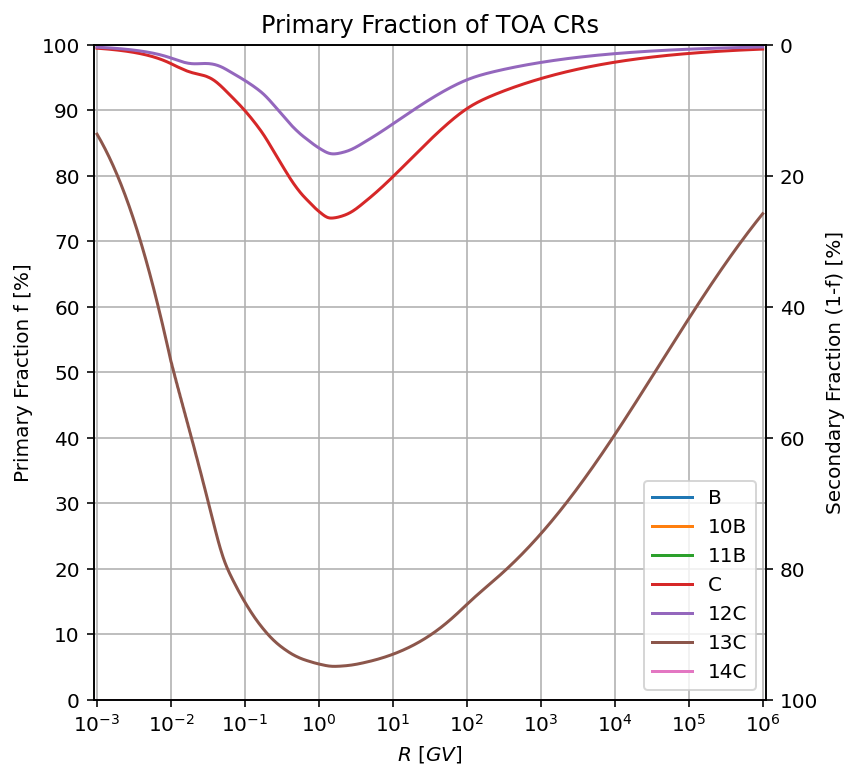

In [74]:
latex_format = {'Va':'V_{a}', 'Vc':'V_c', 'K0':'K_0', 'delta':'\delta', 'eta_t':'\eta_t', 'Rbreak':'R_{break}','Deltabreak':'\delta_{break}','sbreak':'s_{break}','Rlow':'R_{low}', 'deltalow':'\delta_{low}', 'slow':'s_{low}'}


#       Boilerplate
fig,ax = plt.subplots(figsize=(column_width,column_width))
fig.set_dpi(72*2)

plt.xlim(0.0009,1100000)
plt.ylim(0,100)
plt.xscale('log')

plt.title('Primary Fraction of TOA CRs')

plt.grid()
plt.xlabel('$R\ [GV]$')
plt.ylabel('Primary Fraction f [%]')

# Second y axis
ax_twin = ax.twinx()
ax_twin.set_ylabel('Secondary Fraction (1-f) [%]')
ax_twin.set_ylim(100,0)

# ticks
ax.set_xticks([1e-3, 1e-2,1e-1,1e0,1e1,1e2,1e3,1e4,1e5,1e6])
ax.set_yticks(np.linspace(0,100,11))
#ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())


#       Plotting
for key in C_dat:
    if 'primaryfrac' in key:
        if 'fy' not in key:
            label = key.split('_')[1]
            ax.plot(C_dat[key], C_dat[key.replace('fx','fy')], label=label)

ax.legend()

plt.savefig('/home/felix/USINE/gen_graphics/{}_primary_fraction.png'.format(model_dir.split('/')[-1][:-len('_out'):]),bbox_inches='tight')

plt.show()

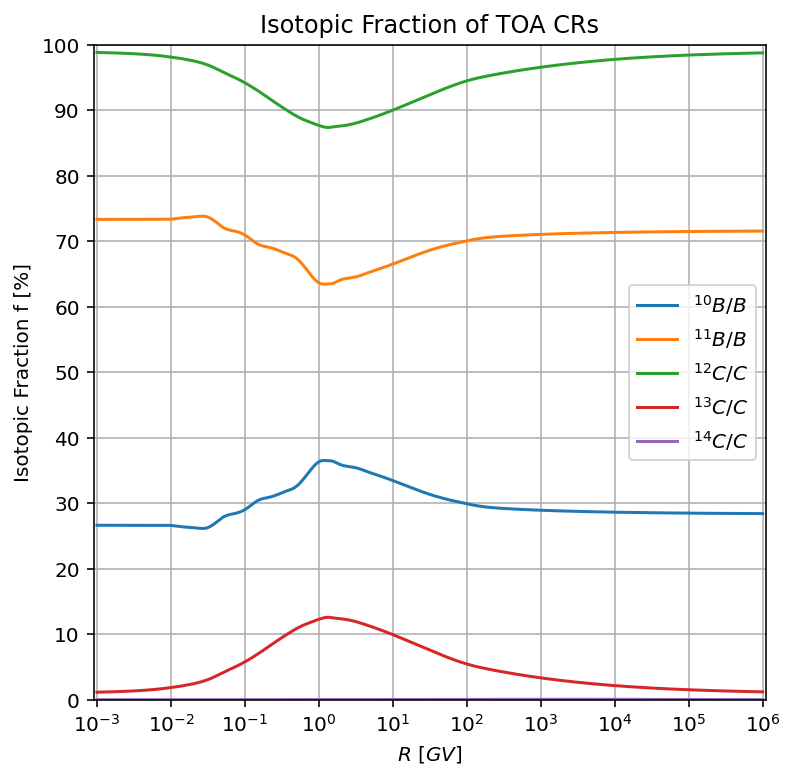

In [75]:
# isotopic fraction plot

#       Boilerplate
fig,ax = plt.subplots(figsize=(column_width,column_width))
fig.set_dpi(72*2)

plt.xlim(0.0009,1100000)
plt.ylim(0,100)
plt.xscale('log')

plt.title('Isotopic Fraction of TOA CRs')

plt.grid()
plt.xlabel('$R\ [GV]$')
plt.ylabel('Isotopic Fraction f [%]')

# Second y axis
#ax_twin = ax.twinx()
#ax_twin.set_ylabel('Secondary Fraction (1-f) [%]')
#ax_twin.set_ylim(100,0)

# ticks
ax.set_xticks([1e-3, 1e-2,1e-1,1e0,1e1,1e2,1e3,1e4,1e5,1e6])
ax.set_yticks(np.linspace(0,100,11))
#ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())


#       Plotting
for key in C_dat:
    if 'isotopicfrac' in key:
        if 'fy' not in key:
            label = key.split('_')[1]
            label = '$^{'+label[0:2]+'}'+label[2]+'/'+label[2]+'$'
            ax.plot(C_dat[key], C_dat[key.replace('fx','fy')], label=label)

ax.legend()

plt.savefig('/home/felix/USINE/gen_graphics/{}_isotopic_fraction.png'.format(model_dir.split('/')[-1][:-len('_out'):]),bbox_inches='tight')

plt.show()

In [76]:
for i in C_dat.keys():
    if 'model_' in i:
        print(i, end=', ')

for i in C_dat.keys():
    if 'data_' in i:
        print(i, end=', ')

model_BC_R_Model1DKisoVc_SolMod0DFF_phi0_670GV__fx3, model_BC_R_Model1DKisoVc_SolMod0DFF_phi0_670GV__fy3, model_C_R_Model1DKisoVc_SolMod0DFF_phi0_670GV__fx2, model_C_R_Model1DKisoVc_SolMod0DFF_phi0_670GV__fy2, model_B_R_Model1DKisoVc_SolMod0DFF_phi0_670GV__fx1, model_B_R_Model1DKisoVc_SolMod0DFF_phi0_670GV__fy1, data_BC_AMS02_201105201605___ErrTotR_fx3001, data_BC_AMS02_201105201605___ErrTotR_fy3001, data_BC_AMS02_201105201605___ErrTotR_felx3001, data_BC_AMS02_201105201605___ErrTotR_fely3001, data_BC_AMS02_201105201605___ErrTotR_fehx3001, data_BC_AMS02_201105201605___ErrTotR_fehy3001, 

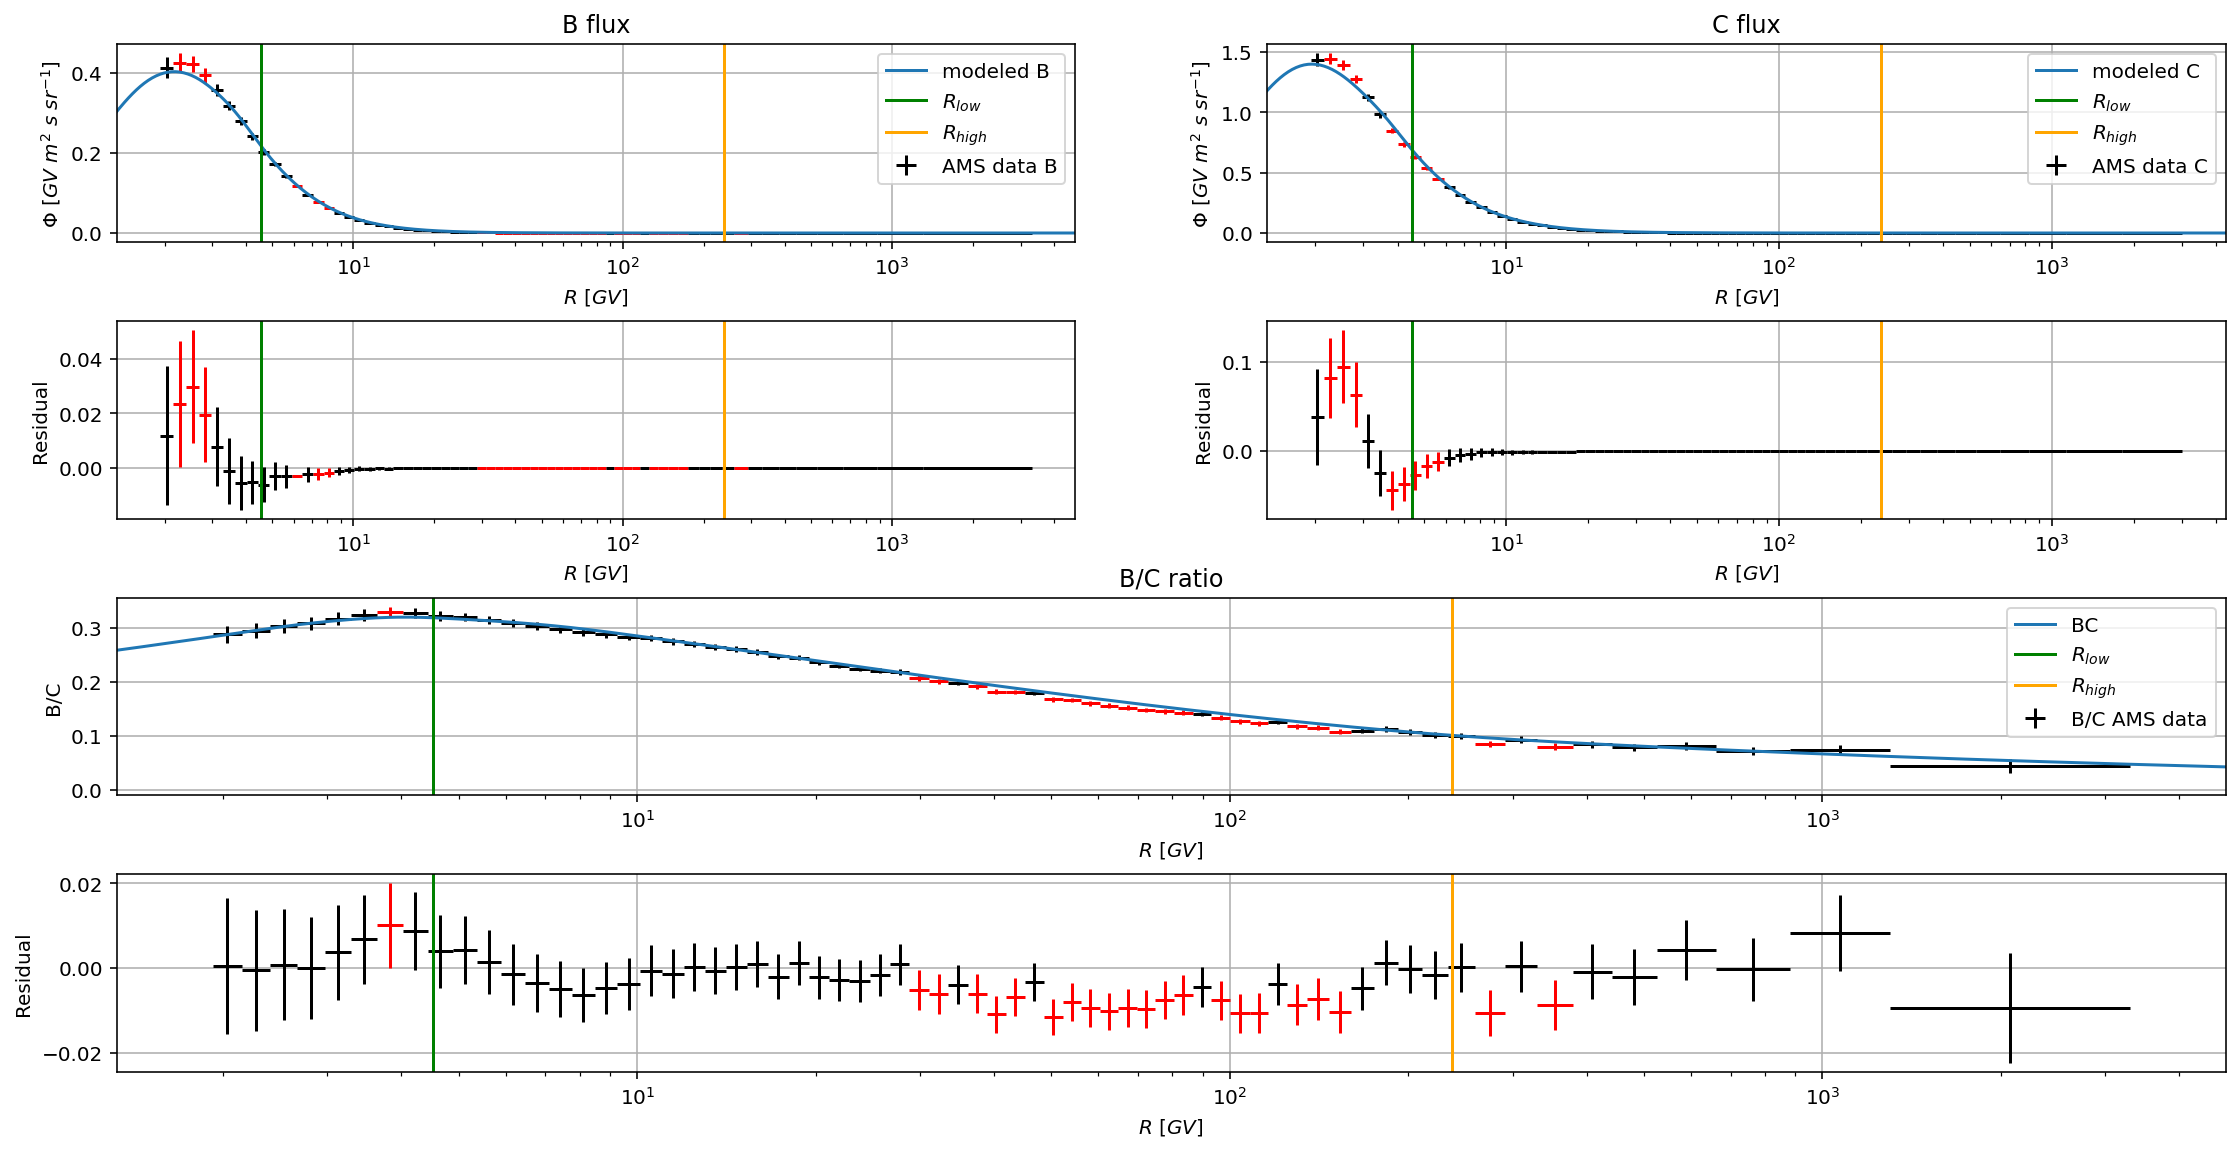

In [95]:
# Primary fraction plot

#       Boilerplate
fig = plt.figure(figsize=(twocolumn_width,0.5*twocolumn_width))
#plt.xlim(0.0009,1100000)
#plt.ylim(0,100)
fig.set_dpi(72*2)



# Second y axis
#ax_twin = ax.twinx()
#ax_twin.set_ylabel('Secondary Fraction (1-f) [%]')
#ax_twin.set_ylim(100,0)

# ticks
#ax.set_xticks([1e-3, 1e-2,1e-1,1e0,1e1,1e2,1e3,1e4,1e5,1e6])
#ax.set_yticks(np.linspace(0,100,11))
#ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.subplots_adjust(hspace=0.4)

#       Plotting
ax1 = fig.add_subplot(4,2,1)
ax1_r = fig.add_subplot(4,2,3)
ax2 = fig.add_subplot(4,2,2)
ax2_r = fig.add_subplot(4,2,4)
ax3 = fig.add_subplot(4,2,(5,6))
ax3_r = fig.add_subplot(4,2,(7,8))
for i in (ax1, ax2, ax3):
    i.set_xscale('log')
    i.set_xlabel('$R\ [GV]$')
    i.grid()

for i in (ax1_r, ax2_r, ax3_r):
    i.set_xscale('log')
    i.set_ylabel('Residual')
    i.set_xlabel('$R\ [GV]$')
    i.grid()

for i in (ax1, ax2):
    i.set_ylabel('$\Phi\ [GV\ m^2\ s\ sr^{-1}]$')

ax3.set_ylabel('B/C')

for key in C_dat:
    if 'model_' in key:
        if 'fy' not in key:
            label = key.split('_')[1]
            if label == 'B':
                data = AMS_data[key.split('_')[1]]
                # Make interpolation to fit to AMS data
                f=interp1d(C_dat[key], C_dat[key.replace('fx','fy')], kind='cubic')
                interpolated_fit = f(data[ '<E>: mean value bin [GeV/n, GeV, GV, or GeV]'])
                # Get coloring scheme
                colors = [data['QUANTITY VALUE: [#/sr/s/m2/EAxis] if flux , no unit if ratio']-interpolated_fit-(data['ERR_STAT']+data['ERR_SYST']), data['QUANTITY VALUE: [#/sr/s/m2/EAxis] if flux , no unit if ratio']-interpolated_fit+(data['ERR_STAT+']+data['ERR_SYST+'])]
                colors = ['black' if i<0<j else 'red' for i,j in zip(colors[0],colors[1])]
                # Plot Graph
                ax1.plot(C_dat[key], C_dat[key.replace('fx','fy')], label='modeled '+label)
                ax1.errorbar(y=data['QUANTITY VALUE: [#/sr/s/m2/EAxis] if flux , no unit if ratio'], x=data[ '<E>: mean value bin [GeV/n, GeV, GV, or GeV]'], xerr=[data['<E>: mean value bin [GeV/n, GeV, GV, or GeV]']-data['EBIN_LOW'], data['EBIN_HIGH']-data['<E>: mean value bin [GeV/n, GeV, GV, or GeV]']], yerr=[data['ERR_STAT']+data['ERR_SYST'], data['ERR_STAT+']+data['ERR_SYST+']] ,label='AMS data '+label,fmt='None',c='black',ecolor=colors)
                ax1.set_title('B flux')
                # Plot residuals
                ax1_r.errorbar(y=data['QUANTITY VALUE: [#/sr/s/m2/EAxis] if flux , no unit if ratio']-interpolated_fit, x=data[ '<E>: mean value bin [GeV/n, GeV, GV, or GeV]'], xerr=[data['<E>: mean value bin [GeV/n, GeV, GV, or GeV]']-data['EBIN_LOW'], data['EBIN_HIGH']-data['<E>: mean value bin [GeV/n, GeV, GV, or GeV]']], yerr=[data['ERR_STAT']+data['ERR_SYST'], data['ERR_STAT+']+data['ERR_SYST+']] ,label='AMS data '+label,fmt='None',c='black',ecolor=colors)

            if label == 'C':
                data = AMS_data[key.split('_')[1]]
                # Make interpolation to fit to AMS data
                f=interp1d(C_dat[key], C_dat[key.replace('fx','fy')], kind='cubic')
                interpolated_fit = f(data[ '<E>: mean value bin [GeV/n, GeV, GV, or GeV]'])
                # Get coloring scheme
                colors = [data['QUANTITY VALUE: [#/sr/s/m2/EAxis] if flux , no unit if ratio']-interpolated_fit-(data['ERR_STAT']+data['ERR_SYST']), data['QUANTITY VALUE: [#/sr/s/m2/EAxis] if flux , no unit if ratio']-interpolated_fit+(data['ERR_STAT+']+data['ERR_SYST+'])]
                colors = ['black' if i<0<j else 'red' for i,j in zip(colors[0],colors[1])]
                # Plot Graph
                ax2.plot(C_dat[key], C_dat[key.replace('fx','fy')], label='modeled '+label)
                ax2.errorbar(y=data['QUANTITY VALUE: [#/sr/s/m2/EAxis] if flux , no unit if ratio'], x=data[ '<E>: mean value bin [GeV/n, GeV, GV, or GeV]'], xerr=[data['<E>: mean value bin [GeV/n, GeV, GV, or GeV]']-data['EBIN_LOW'], data['EBIN_HIGH']-data['<E>: mean value bin [GeV/n, GeV, GV, or GeV]']], yerr=[data['ERR_STAT']+data['ERR_SYST'], data['ERR_STAT+']+data['ERR_SYST+']] ,label='AMS data '+label,fmt='None',c='black',ecolor=colors)
                ax2.set_title('C flux')
                # Plot residuals
                ax2_r.errorbar(y=data['QUANTITY VALUE: [#/sr/s/m2/EAxis] if flux , no unit if ratio']-interpolated_fit, x=data[ '<E>: mean value bin [GeV/n, GeV, GV, or GeV]'], xerr=[data['<E>: mean value bin [GeV/n, GeV, GV, or GeV]']-data['EBIN_LOW'], data['EBIN_HIGH']-data['<E>: mean value bin [GeV/n, GeV, GV, or GeV]']], yerr=[data['ERR_STAT']+data['ERR_SYST'], data['ERR_STAT+']+data['ERR_SYST+']] ,label='AMS data '+label,fmt='None',c='black',ecolor=colors)
            if label == 'BC':
                # Make interpolation to fit to AMS data for residuals
                name = [i for i in C_dat.keys() if 'data_' in i and 'fx' in i and label in i][0]
                f=interp1d(C_dat[key], C_dat[key.replace('fx','fy')], kind='cubic')
                interpolated_fit = f(C_dat[name])
                # Get coloring scheme
                colors = [C_dat[name.replace('fx','fy')]-interpolated_fit-C_dat[name.replace('fx','fely')], C_dat[name.replace('fx','fy')]-interpolated_fit+C_dat[name.replace('fx','fehy')]]
                colors = ['black' if i<0<j else 'red' for i,j in zip(colors[0],colors[1])]
                # Plot Graph
                ax3.set_title('B/C ratio')
                ax3.plot(C_dat[key], C_dat[key.replace('fx','fy')], label=label)
                # Get AMS data and plot
                if label == 'BC': label = 'B/C'
                ax3.errorbar(x=C_dat[name], y=C_dat[name.replace('fx','fy')],yerr= [C_dat[name.replace('fx','fely')], C_dat[name.replace('fx','fehy')]],xerr= [C_dat[name.replace('fx','felx')], C_dat[name.replace('fx','fehx')]],label=label+' AMS data',fmt='None',c='black',ecolor=colors)
                # Plot residuals
                ax3_r.errorbar(x=C_dat[name], y=C_dat[name.replace('fx','fy')]-interpolated_fit,yerr= [C_dat[name.replace('fx','fely')], C_dat[name.replace('fx','fehy')]],xerr= [C_dat[name.replace('fx','felx')], C_dat[name.replace('fx','fehx')]],label=label+' AMS data',fmt='None',ecolor=colors)


for i in (ax1, ax2, ax3,ax1_r, ax2_r, ax3_r):
    i.axvline(transport_params['R_{low} (GV)'],label='$R_{low}$',c='green')
    i.axvline(transport_params['R_{break} (GV)'],label='$R_{high}$',c='orange')
for i in (ax1, ax2, ax3):
    i.legend()
for i in ((ax1,ax1_r), (ax2,ax2_r), (ax3, ax3_r)):
    i[0].set_xlim(i[1].get_xlim())



plt.savefig('/home/felix/USINE/gen_graphics/{}_fluxes.png'.format(model_dir.split('/')[-1][:-len('_out'):]),bbox_inches='tight')
plt.show()


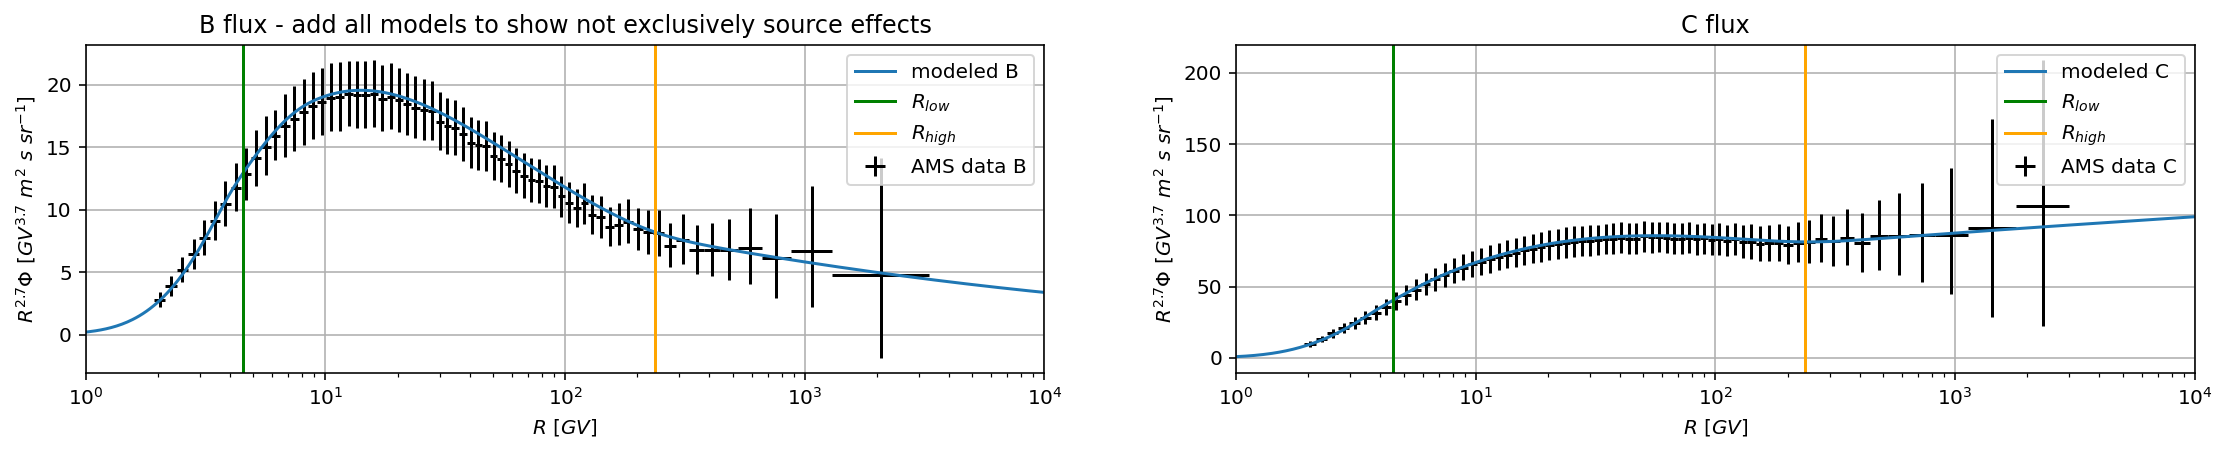

In [109]:
# Primary fraction plot

#       Boilerplate
fig = plt.figure(figsize=(twocolumn_width,0.5*column_width))
#plt.xlim(0.0009,1100000)
#plt.ylim(0,100)
fig.set_dpi(72*2)



# Second y axis
#ax_twin = ax.twinx()
#ax_twin.set_ylabel('Secondary Fraction (1-f) [%]')
#ax_twin.set_ylim(100,0)

# ticks
#ax.set_xticks([1e-3, 1e-2,1e-1,1e0,1e1,1e2,1e3,1e4,1e5,1e6])
#ax.set_yticks(np.linspace(0,100,11))
#ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.subplots_adjust(hspace=0.2)

#       Plotting
ax1 = fig.add_subplot(1,2,1)
#ax1_r = fig.add_subplot(2,2,3)
ax2 = fig.add_subplot(1,2,2)
#ax2_r = fig.add_subplot(2,2,4)
for i in (ax1, ax2):
    i.set_xscale('log')
    i.set_xlabel('$R\ [GV]$')
    i.grid()

#for i in (ax1_r, ax2_r):
#    i.set_xscale('log')
#    i.set_ylabel('Residual')
#    i.set_xlabel('$R\ [GV]$')
#    i.grid()

for i in (ax1, ax2):
    i.set_ylabel('$R^{2.7}\Phi\ [GV^{3.7}\ m^2\ s\ sr^{-1}]$')

ax3.set_ylabel('B/C')

for key in C_dat:
    if 'model_' in key:
        if 'fy' not in key:
            label = key.split('_')[1]
            if label == 'B':
                data = AMS_data[key.split('_')[1]]
                # Make interpolation to fit to AMS data
                f=interp1d(C_dat[key], C_dat[key.replace('fx','fy')], kind='cubic')
                interpolated_fit = f(data[ '<E>: mean value bin [GeV/n, GeV, GV, or GeV]']) 
                #   Plot Graph
                # Model data
                y_model_scaled = np.array(C_dat[key.replace('fx','fy')])*np.array(C_dat[key])**2.7
                x_model = np.array(C_dat[key])
                ax1.plot(x_model, y_model_scaled, label='modeled '+label)

                # AMS data
                y_AMS_scaled            = np.array(data['QUANTITY VALUE: [#/sr/s/m2/EAxis] if flux , no unit if ratio'])*np.array(data[ '<E>: mean value bin [GeV/n, GeV, GV, or GeV]'])**2.7
                #                          ys_err = (2.7*xerr/x + yerr/y)*ys
                y_AMS_error_scaled      = [(2.7* ((data['<E>: mean value bin [GeV/n, GeV, GV, or GeV]']-data['EBIN_LOW'])/data[ '<E>: mean value bin [GeV/n, GeV, GV, or GeV]']) + (data['ERR_STAT']+data['ERR_SYST'])/np.array(data['QUANTITY VALUE: [#/sr/s/m2/EAxis] if flux , no unit if ratio']))*y_AMS_scaled, (2.7* ((data['EBIN_HIGH']-data['<E>: mean value bin [GeV/n, GeV, GV, or GeV]'])/data[ '<E>: mean value bin [GeV/n, GeV, GV, or GeV]']) + (data['ERR_STAT+']+data['ERR_SYST+'])/np.array(data['QUANTITY VALUE: [#/sr/s/m2/EAxis] if flux , no unit if ratio']))*y_AMS_scaled]
                x_AMS                   = data[ '<E>: mean value bin [GeV/n, GeV, GV, or GeV]']
                x_AMS_error             = [data['<E>: mean value bin [GeV/n, GeV, GV, or GeV]']-data['EBIN_LOW'], data['EBIN_HIGH']-data['<E>: mean value bin [GeV/n, GeV, GV, or GeV]']]

                ax1.errorbar(y=y_AMS_scaled, x=x_AMS, xerr=x_AMS_error, yerr=y_AMS_error_scaled ,label='AMS data '+label,fmt='None',c='black')
                ax1.set_title('B flux - add all models to show not exclusively source effects')
                # Plot residuals
                #ax1_r.errorbar(y=data['QUANTITY VALUE: [#/sr/s/m2/EAxis] if flux , no unit if ratio']-interpolated_fit, x=data[ '<E>: mean value bin [GeV/n, GeV, GV, or GeV]'], xerr=x_AMS_error, yerr=y_AMS_error_scaled ,label='AMS data '+label,fmt='None',c='black')
                #ax1_r.plot(data[ '<E>: mean value bin [GeV/n, GeV, GV, or GeV]'],data['QUANTITY VALUE: [#/sr/s/m2/EAxis] if flux , no unit if ratio']-interpolated_fit)

            if label == 'C':
                data = AMS_data[key.split('_')[1]]
                # Make interpolation to fit to AMS data
                f=interp1d(C_dat[key], C_dat[key.replace('fx','fy')], kind='cubic')
                interpolated_fit = f(data[ '<E>: mean value bin [GeV/n, GeV, GV, or GeV]']) 
                #   Plot Graph
                # Model data
                y_model_scaled = np.array(C_dat[key.replace('fx','fy')])*np.array(C_dat[key])**2.7
                x_model = np.array(C_dat[key])
                ax2.plot(x_model, y_model_scaled, label='modeled '+label)

                # AMS data
                y_AMS_scaled            = np.array(data['QUANTITY VALUE: [#/sr/s/m2/EAxis] if flux , no unit if ratio'])*np.array(data[ '<E>: mean value bin [GeV/n, GeV, GV, or GeV]'])**2.7
                #                          ys_err = (2.7*xerr/x + yerr/y)*ys
                y_AMS_error_scaled      = [(2.7* ((data['<E>: mean value bin [GeV/n, GeV, GV, or GeV]']-data['EBIN_LOW'])/data[ '<E>: mean value bin [GeV/n, GeV, GV, or GeV]']) + (data['ERR_STAT']+data['ERR_SYST'])/np.array(data['QUANTITY VALUE: [#/sr/s/m2/EAxis] if flux , no unit if ratio']))*y_AMS_scaled, (2.7* ((data['EBIN_HIGH']-data['<E>: mean value bin [GeV/n, GeV, GV, or GeV]'])/data[ '<E>: mean value bin [GeV/n, GeV, GV, or GeV]']) + (data['ERR_STAT+']+data['ERR_SYST+'])/np.array(data['QUANTITY VALUE: [#/sr/s/m2/EAxis] if flux , no unit if ratio']))*y_AMS_scaled]
                x_AMS                   = data[ '<E>: mean value bin [GeV/n, GeV, GV, or GeV]']
                x_AMS_error             = [data['<E>: mean value bin [GeV/n, GeV, GV, or GeV]']-data['EBIN_LOW'], data['EBIN_HIGH']-data['<E>: mean value bin [GeV/n, GeV, GV, or GeV]']]

                ax2.errorbar(y=y_AMS_scaled, x=x_AMS, xerr=x_AMS_error, yerr=y_AMS_error_scaled ,label='AMS data '+label,fmt='None',c='black')
                ax2.set_title('C flux')
                # Plot residuals
                #ax2_r.plot(data[ '<E>: mean value bin [GeV/n, GeV, GV, or GeV]'],data['QUANTITY VALUE: [#/sr/s/m2/EAxis] if flux , no unit if ratio']-interpolated_fit)
                #ax2_r.errorbar(y=data['QUANTITY VALUE: [#/sr/s/m2/EAxis] if flux , no unit if ratio']-interpolated_fit, x=data[ '<E>: mean value bin [GeV/n, GeV, GV, or GeV]'], xerr=x_AMS_error, yerr=y_AMS_error_scaled ,label='AMS data '+label,fmt='None',c='black')



for i in (ax1, ax2):#,ax1_r, ax2_r
    i.axvline(transport_params['R_{low} (GV)'],label='$R_{low}$',c='green')
    i.axvline(transport_params['R_{break} (GV)'],label='$R_{high}$',c='orange')
for i in (ax1, ax2):
    i.legend()
    i.set_xlim(1,1e4)
#for i in ((ax1,ax1_r), (ax2,ax2_r)):
#    i[0].set_xlim(i[1].get_xlim())
#    i[1].set_ylim(-0.1,0.1)
#ax1_r.set_title('Residual plots absolutely meaningless in this context')
#ax2_r.set_title('Residual plots absolutely meaningless in this context')
plt.savefig('/home/felix/USINE/gen_graphics/all_scaled_fluxes.png'.format(model_dir.split('/')[-1][:-len('_out'):]),bbox_inches='tight')
plt.show()


## Diffusion coefficient behavior

Cant plot beta^eta as beta is transport dependent 

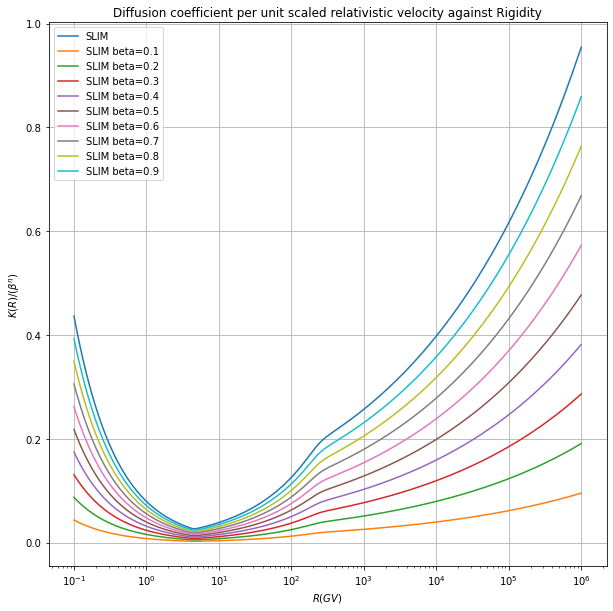

In [42]:
# Get data for all models
model_paths = '/home/felix/USINE/'

model_val_files ={}
for i in os.listdir(model_paths):
    if 'out' in i:
        model_val_files['_'.join(i.split('_')[:-1:])]=os.path.join(model_paths, i,'model_vals_pars.out')

# Extract transport parameters
for i in model_val_files:
    with open(model_val_files[i], 'r') as f:
        lines = f.readlines()
        cond = False
    for line in lines:
        if '# Source' in line:
            cond = False
            break 
        if cond and line!='\n':
            key, value = line.split('=')
            # Latex format key
            key = latex_format[key.strip(' ')]
            # Add units
            key = key + ' (' + value.split('[')[1].split(']')[0] + ')'
            if key.strip(' ') not in transport_params.keys():   
                transport_params[key.strip(' ')] = [float(value.split('[')[0].strip(' '))]
            else:
                transport_params[key.strip(' ')].append(float(value.split('[')[0].strip(' ')))
        if '# Transport' in line:
            cond = True


def diff_coeff_func(K10,delta,deltal,deltah, sl,sh,Rl,Rh,R):
    return K10*(1+(R/Rl)**((deltal-delta)/sl))**(sl)*(R/10)**(delta)*(1+(R/Rh)**((delta-deltah)/sh))**(-sh)



rigidity = np.logspace(-1,6,1000)
diff_coeff = {}
count=0
for i in model_val_files:
    diff_coeff[i] = [diff_coeff_func(transport_params['K_0 (kpc^2/Myr)'][count],
                                    transport_params['\\delta (-)'][count],
                                    transport_params['\\delta_{low} (-)'][count],
                                    transport_params['\\delta_{break} (-)'][count],
                                    transport_params['s_{low} (-)'][count],
                                    transport_params['s_{break} (-)'][count], # TODO: Is break high?
                                    transport_params['R_{low} (GV)'][count],
                                    transport_params['R_{break} (GV)'][count],
                                    R ) for R in rigidity]
    count+=1

fig = plt.figure(figsize=(10,10))

plt.xscale('log')

plt.ylabel(r'$K(R)/(\beta^{\eta})$')
plt.xlabel(r'$R (GV)$')
plt.title(r'Diffusion coefficient per unit scaled relativistic velocity against Rigidity') 
count=0
for i in diff_coeff:
    plt.plot(rigidity,diff_coeff[i],label=i)
    # Plot v based remove this
    for j in range(1,10):
        plt.plot(rigidity,[k*(j/10)**(transport_params['\\eta_t (-)'][count]) for k in diff_coeff[i]],label=i+' beta=0.{}'.format(j))
    count+=1
    break


plt.grid()
plt.legend()

plt.savefig('/home/felix/USINE/gen_graphics/diff_coeff_vs_rigidity.png',bbox_inches='tight')

In [39]:
transport_params.keys()

dict_keys(['V_{a} (km/s)', 'V_c (km/s)', 'K_0 (kpc^2/Myr)', '\\delta (-)', '\\eta_t (-)', 'R_{break} (GV)', '\\delta_{break} (-)', 's_{break} (-)', 'R_{low} (GV)', '\\delta_{low} (-)', 's_{low} (-)'])

## Below is vals_out automatic table formating

In [6]:
# Create Latex table of major parameters

model_paths = '/home/felix/USINE/'

model_val_files ={}
for i in os.listdir(model_paths):
    if 'out' in i:
        model_val_files['_'.join(i.split('_')[:-1:])]=os.path.join(model_paths, i,'model_vals_pars.out')

#Key latex fomatting dict for transport table
latex_format = {'Va':'V_{a}', 'Vc':'V_c', 'K0':'K_0', 'delta':'\delta', 'eta_t':'\eta_t', 'Rbreak':'R_{break}','Deltabreak':'\delta_{break}','sbreak':'s_{break}','Rlow':'R_{low}', 'deltalow':'\delta_{low}', 'slow':'s_{low}'}

transport_params = {}

source_params = {}

# Extract transport parameters
for i in model_val_files:
    with open(model_val_files[i], 'r') as f:
        lines = f.readlines()
        cond = False
    for line in lines:
        if '# Source' in line:
            cond = False
            break 
        if cond and line!='\n':
            key, value = line.split('=')
            # Latex format key
            key = latex_format[key.strip(' ')]
            # Add units
            key = key + ' (' + value.split('[')[1].split(']')[0] + ')'
            if key.strip(' ') not in transport_params.keys():   
                transport_params[key.strip(' ')] = [float(value.split('[')[0].strip(' '))]
            else:
                transport_params[key.strip(' ')].append(float(value.split('[')[0].strip(' ')))
        if '# Transport' in line:
            cond = True
        
# Extract Source parameters
for i in model_val_files:
    with open(model_val_files[i], 'r') as f:
        lines = f.readlines()
        cond = False
    for line in lines:
        if cond and line!='\n':
            key, value = line.split('=')
            # Add units
            key = key + ' (' + value.split('[')[1].split(']')[0] + ')'
            if key.strip(' ') not in source_params.keys():   
                source_params[key.strip(' ')] = [float(value.split('[')[0].strip(' '))]
            else:
                source_params[key.strip(' ')].append(float(value.split('[')[0].strip(' ')))
        if '# Source' in line:
            cond = True
        


latexfile = 'tables.tex'


tableheader = '\\begin{tabular}{'+('c |'*(len(model_val_files)+1))[:-2:]+'}'

with open(latexfile, 'w') as f:
    # Preamble transport parameters
    f.write('Transport parameters:\n\n')
    f.write(tableheader+'\n')
    f.write('\tParameters & '+('{} &' *len(model_val_files)).format(*model_val_files.keys())[:-2:]+' \\\\ \n')
    f.write('\t\\cline\x7B1-'+str((len(model_val_files)+1))+'\x7D\n')
    # Actual Content
    for key in transport_params.keys():
        f.write('\t$'+key+'$ & '+('${}$ &' *len(model_val_files)).format(*transport_params[key])[:-2:]+' \\\\ \n')
    f.write('\end{tabular}\n\n')

    # Preamble Source parameters
    f.write('Source parameters:\n\n')
    f.write(tableheader+'\n')
    f.write('\tParameters & '+('{} &' *len(model_val_files)).format(*model_val_files.keys())[:-2:]+' \\\\ \n')
    f.write('\t\\cline\x7B1-'+str((len(model_val_files)+1))+'\x7D\n')
    # Actual Content
    for key in source_params.keys():
        # Format elemental notation
        if 'q_' in key:
            name, unit = [i for i in key.split(' ') if i]
            if name[2:4:].isnumeric():
                nucleon_nr = name[2:4:]
                elem = name[4::]
            elif name[2].isnumeric():
                nucleon_nr = name[2]
                elem= name[3::]
            else:
                print(name)
            if len(elem) > 1:
                elem = elem[0].upper() + elem[1::].lower()
            name='q_\x7B^\x7B'+nucleon_nr+'\x7D'+elem+'\x7D '+unit
        # Format elemental notation and alpha
        if 'alpha' in key:
            quant, name = [i for i in key.split(' ')[0].split('_') if i]
            if name[0:2:].isnumeric():
                nucleon_nr = name[0:2:]
                elem = name[2::]
            elif name[0].isnumeric():
                nucleon_nr = name[0]
                elem= name[1::]
            else:
                print(name)
                nucleon_nr = ''
                elem = name
            if len(elem) > 1:
                elem = elem[0].upper() + elem[1::].lower()
            name = '\\alpha_\x7B^\x7B'+nucleon_nr+'\x7D'+elem+'\x7D'
        if 'eta' in key:
            name = '\\'+key
        f.write('\t$'+name+'$ & '+('${}$ &' *len(model_val_files)).format(*source_params[key])[:-2:]+' \\\\ \n')
    f.write('\end{tabular}\n\n')


SLIM_out
SLIM_ALLSPECTRUM_out
{'SLIM': '/home/felix/USINE/SLIM_out/model_vals_pars.out', 'SLIM_ALLSPECTRUM': '/home/felix/USINE/SLIM_ALLSPECTRUM_out/model_vals_pars.out'}
DEFAULT


{'V_{a} (km/s)': [7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0],
 'V_c (km/s)': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 'K_0 (kpc^2/Myr)': [0.03890451,
  0.03890451,
  0.03890451,
  0.03890451,
  0.03890451,
  0.03890451,
  0.03890451,
  0.03890451,
  0.03890451,
  0.0389045